<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/stocks_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yahoo_fin
# !pip install mplfinance

In [4]:
# import yfinance as yf
# import yahoo_fin.stock_info as si
# import mplfinance as mpf
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import random
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
savePath ='/content/drive/MyDrive/myStocksSept2024/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



*   loading and unzipping of data
*   uniting plots into two channel images
*   visualize a random sample
*   visualize target distributions
*   remove outliers ???
*   create train and validation and test datasets
*   create cnn
*   test run on a single batch
*   create training function
*   train model
*   plot results


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_morebalanced_pool3_asHalf.pt')
images = torch.load(savePath+'images_allStocks_midAndExtremes_morebalanced_pool3_asHalf.pt')
print(images.shape)
print(targets.shape)

In [ ]:
images = torch.load(savePath+'images_allStocks_midAndExtremes_every3rdImg_pool3_asHalf.pt')
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_every3rdImg_pool3_asHalf.pt')
print(images.shape)
print(targets.shape)

In [5]:
images = torch.load(savePath+'images_allStocks_midAndExtremes_every2ndImg_pool3_asHalf.pt')
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_every2ndImg_pool3_asHalf.pt')
print(images.shape)
print(targets.shape)

torch.Size([121215, 2, 106, 106])
torch.Size([121215])


In [ ]:
images = torch.load(savePath+'images_allStocks_midAndExtremes_every2ndImg_offset1_pool3_asHalf.pt')
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_every2ndImg_offset1_pool3_asHalf.pt')
print(images.shape)
print(targets.shape)

torch.Size([121212, 2, 106, 106])
torch.Size([121212])


In [ ]:
# Distribution of labels
print(f'percent of positive above 10% targets in dataset: {round((sum(targets>=0.1)/len(targets)).detach().item()*100,2)} %')
print(f'percent of negative below -10% targets in dataset: {round((sum(targets<=-0.1)/len(targets)).detach().item()*100,2)} %')
print(f'percent of between -5% and 5% targets in dataset: {round((sum((0.1>targets)&(targets>-0.1))/len(targets)).detach().item()*100,2)} %')


percent of positive above 10% targets in dataset: 15.21 %
percent of negative below -10% targets in dataset: 16.64 %
percent of between -5% and 5% targets in dataset: 68.15 %


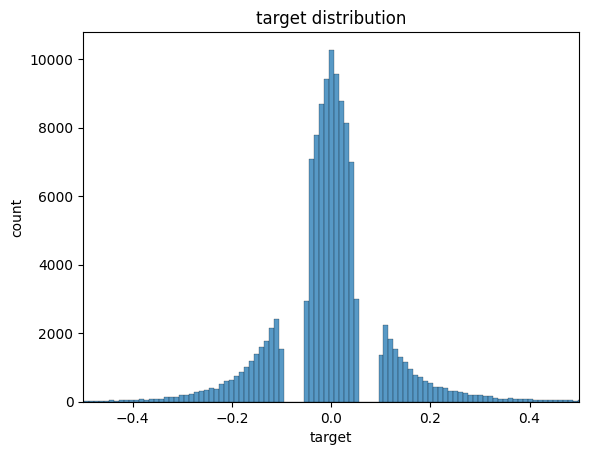

In [ ]:
sns.histplot(targets,bins=np.linspace(-1,1,200))
plt.title('target distribution')
plt.xlim(-0.5,0.5)
plt.xlabel('target')
plt.ylabel('count')
plt.show()

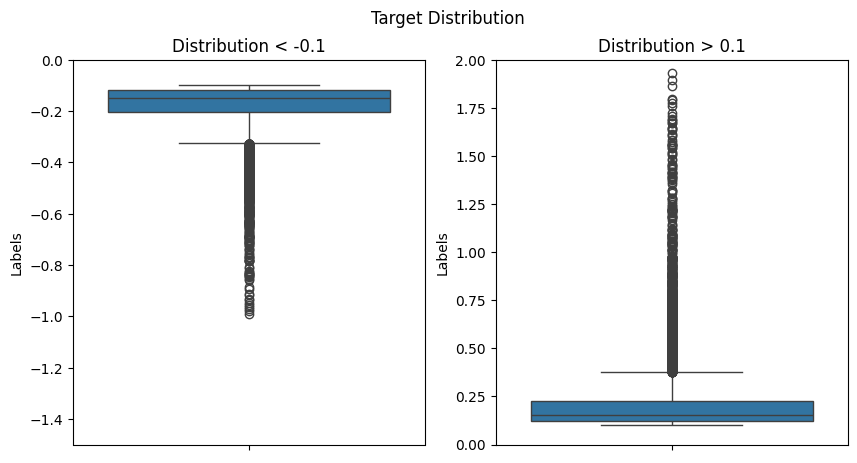

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=targets[targets<-0.1].detach().numpy(), ax=ax[0])
sns.boxplot(y=targets[targets>0.1].detach().numpy(), ax=ax[1])

ax[0].set_ylim(-1.5, 0)
ax[1].set_ylim(0, 2)
ax[0].set_title('Distribution < -0.1')
ax[1].set_title('Distribution > 0.1')
ax[0].set_ylabel('Labels')
ax[1].set_ylabel('Labels')
fig.suptitle('Target Distribution')

plt.show()


In [ ]:
# define outliers
indices_neg = torch.nonzero((targets <= -0.1) & (targets >= -0.3)).squeeze()
indices_pos = torch.nonzero((targets >= 0.1) & (targets <= 0.3)).squeeze()
indices_mid = torch.nonzero((targets >= -0.05) & (targets <= 0.05)).squeeze()
indices_wo_outliers = torch.cat((indices_neg, indices_mid,indices_pos))
print(f'percent of targets after removing outliers: {100*len(indices_wo_outliers)/len(targets)} %')


percent of targets after removing outliers: 96.70255331435878 %


In [ ]:
# removing of outliers
images = images[indices_wo_outliers].half()
targets = targets[indices_wo_outliers].half()
print(images.shape)
print(targets.shape)

torch.Size([117218, 2, 106, 106])
torch.Size([117218])


In [24]:
import matplotlib.patches as mpatches

def generateLabelHistogram(label_count, targets):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    bins = np.linspace(-1, 1, num=500)

    # Plot the histogram initially with lightgray and black edge colors
    hist1 = sns.histplot(targets.numpy(), bins=bins, color='lightgray', edgecolor='white', kde=False, ax=ax)
    counts, edges = np.histogram(targets.numpy(), bins=bins)

    # Define the low and high values for each label in sorted order
    lows = [torch.min(targets[labels == key]).item() for key, value in sorted(label_count.items())]
    highs = [torch.max(targets[labels == key]).item() for key, value in sorted(label_count.items())]

    # Set up the colormap with more divisions for values below -0.1
    cmap1 = plt.cm.get_cmap('coolwarm', 1000)  # Increase the number of color divisions for better resolution
    colors = [cmap1(i / (len(label_count) - 1)) for i in range(len(label_count))]

    # Create color_ranges with ranges for each color
    color_ranges = {}
    for i, (low, high) in enumerate(zip(lows, highs)):
        color_ranges[colors[i]] = (low, high)

    # Adjust color bins below -0.1 to have more granularity
    for i in range(len(counts)):

        # Determine the color for this bin based on the defined ranges
        bin_color = 'gray'  # Default color
        for color, (lower, upper) in color_ranges.items():
            if lower <= edges[i] < upper:
                hist1.patches[i].set_facecolor(color)

    # Create the label text with colored circles
    label_count_text = 'Label Frequency\n'
    for idx, (key, value) in enumerate(sorted(label_count.items())):
        color_circle = mpatches.Circle((0, 0), radius=0.1, color=colors[idx])  # Create a circle patch for each label color
        label_text = f'{key} : {round(value / np.sum(list(label_count.values())), 3)}'
        # Remove bbox frame by setting 'facecolor' to 'none' and omitting 'edgecolor'
        ax.text(0.95, 0.95 - (idx * 0.05), f'{label_text}', fontsize=7,
                ha='right', va='top', transform=ax.transAxes)
        ax.add_patch(mpatches.Circle((0.87, 0.94 - (idx * 0.05)), 0.01, color=colors[idx], transform=ax.transAxes, clip_on=False))

    ax.set_xlabel('Targets')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-0.75, 0.75)
    ax.set_title(f'Target Distribution with {len(label_count)} Labels')
    plt.tight_layout()
    plt.show()

    return


In [ ]:
# For binary cross entropy with 2 labels
labels = (targets > 0).float()
labels = labels.unsqueeze(1)
print(labels.shape)

torch.Size([78159, 1])


Counter({1: 82609, 0: 20171, 2: 18435})
0 : 0.166 | 1 : 0.682 | 2 : 0.152
[6.009369887462198, 1.4673340677165927, 6.57526444263629]


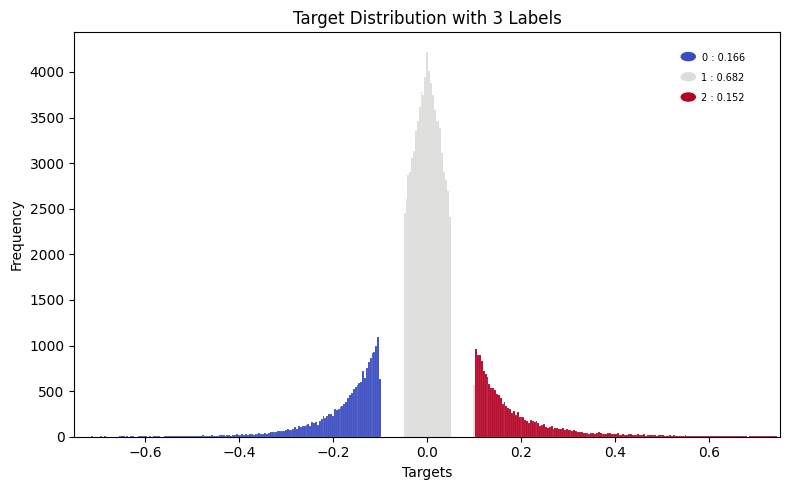

In [25]:
# For cross entropy with 3 labels
labels = torch.zeros_like(targets).long()
labels[targets >= 0.1] = 2
labels[(targets > -0.1) & (targets < 0.1)] = 1
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [1/(value / np.sum(list(label_count.values()))) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

Counter({2: 41554, 1: 41047, 0: 20179, 3: 18435})
0 : 0.166 | 1 : 0.339 | 2 : 0.343 | 3 : 0.152
[6.006987462213192, 2.9530781786732283, 2.917047696972614, 6.57526444263629]


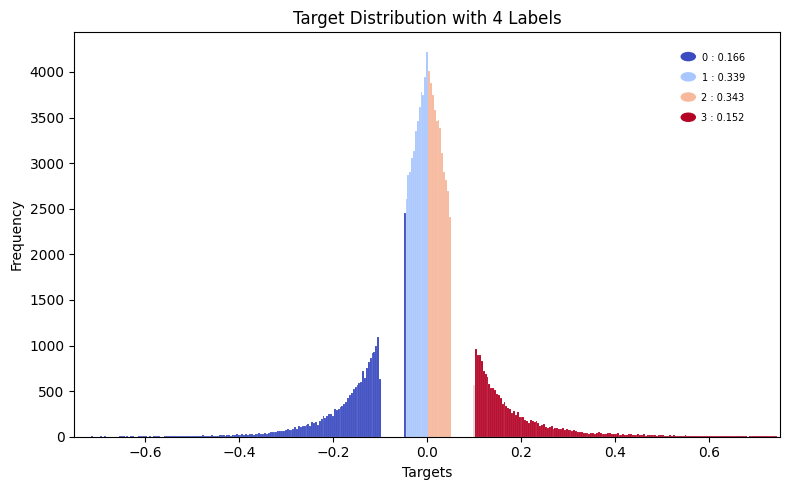

In [26]:
# For cross entropy with 4 labels
labels = torch.zeros_like(targets).long()
labels[targets >= 0.1] = 3
labels[(targets < 0.05)&(targets>=0.0)] = 2
labels[(targets < 0.0)&(targets>=-0.05)] = 1
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [1/(value / np.sum(list(label_count.values()))) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

Counter({3: 41554, 2: 41047, 0: 10104, 1: 10075, 5: 9648, 4: 8787})
0 : 0.083 | 1 : 0.083 | 2 : 0.339 | 3 : 0.343 | 4 : 0.072 | 5 : 0.08
[11.996733966745843, 12.031265508684864, 2.9530781786732283, 2.917047696972614, 13.794810515534312, 12.563743781094528]


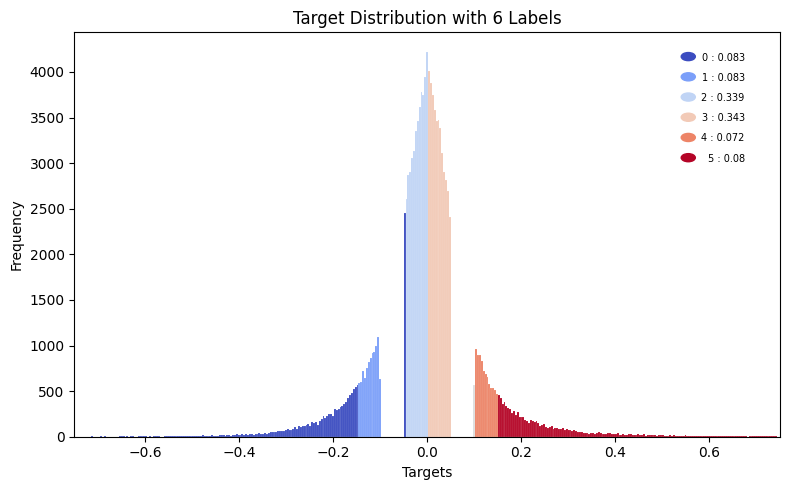

In [27]:
# For cross entropy with 6 labels
labels = torch.zeros_like(targets).long()
labels[targets >= 0.15] = 5
labels[(targets < 0.15)&(targets>=0.1)] = 4
labels[(targets < 0.05)&(targets>=0.0)] = 3
labels[(targets < 0.0)&(targets>=-0.05)] = 2
labels[(targets > -0.15)&(targets<=-0.1)] = 1
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [1/(value / np.sum(list(label_count.values()))) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

Counter({0: 10104, 1: 10075, 7: 9962, 6: 9801, 12: 9648, 5: 9096, 8: 9012, 13: 8787, 9: 8601, 4: 8216, 3: 7486, 10: 7447, 11: 6532, 2: 6448})
0 : 0.083 | 1 : 0.083 | 2 : 0.053 | 3 : 0.062 | 4 : 0.068 | 5 : 0.075 | 6 : 0.081 | 7 : 0.082 | 8 : 0.074 | 9 : 0.071 | 10 : 0.061 | 11 : 0.054 | 12 : 0.08 | 13 : 0.072
[11.996733966745843, 12.031265508684864, 18.798852357320097, 16.19222548757681, 14.753529698149952, 13.326187335092348, 12.367615549433733, 12.167737402128086, 13.450399467376831, 14.093128705964423, 16.2770243050893, 18.557103490508265, 12.563743781094528, 13.794810515534312]


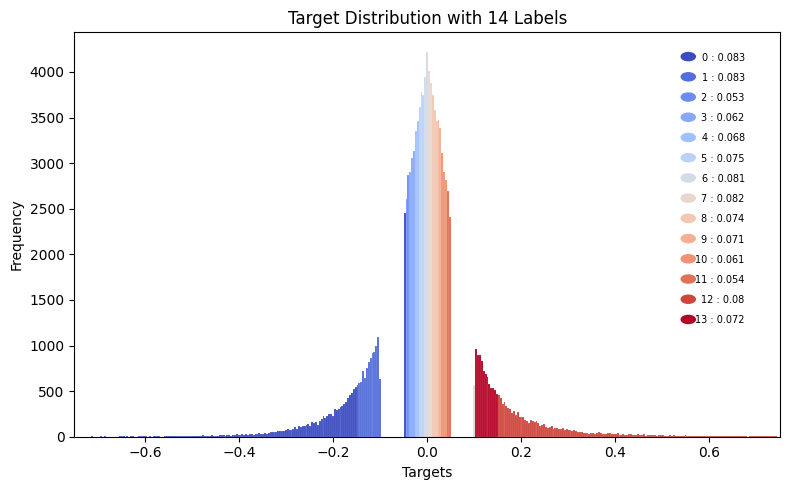

In [28]:
# For cross entropy with 14 ~balanced labels
labels = torch.zeros_like(targets).long()
edges = np.linspace(-0.05,0.05,11)
label = 2
for low_edge,high_edge in zip(edges[:-1],edges[1:]):
  labels[(targets < high_edge)&(targets>=low_edge)] = label
  label+=1

labels[targets >= 0.15] = label
labels[(targets < 0.15)&(targets>=0.1)] = label+1
labels[(targets > -0.15)&(targets<=-0.1)] = 1
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [1/(value / np.sum(list(label_count.values()))) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

Counter({6: 41562, 5: 41047, 4: 10089, 7: 8787, 3: 4867, 8: 3971, 11: 2460, 2: 2373, 9: 2044, 0: 1547, 1: 1295, 10: 1173})
0 : 0.013 | 1 : 0.011 | 2 : 0.02 | 3 : 0.04 | 4 : 0.083 | 5 : 0.339 | 6 : 0.343 | 7 : 0.072 | 8 : 0.033 | 9 : 0.017 | 10 : 0.01 | 11 : 0.02
[78.35488041370394, 93.60231660231659, 51.08091024020227, 24.90548592562153, 12.014570324115374, 2.9530781786732283, 2.9164862133679805, 13.794810515534312, 30.525056660790735, 59.30283757338552, 103.33759590792839, 49.27439024390244]


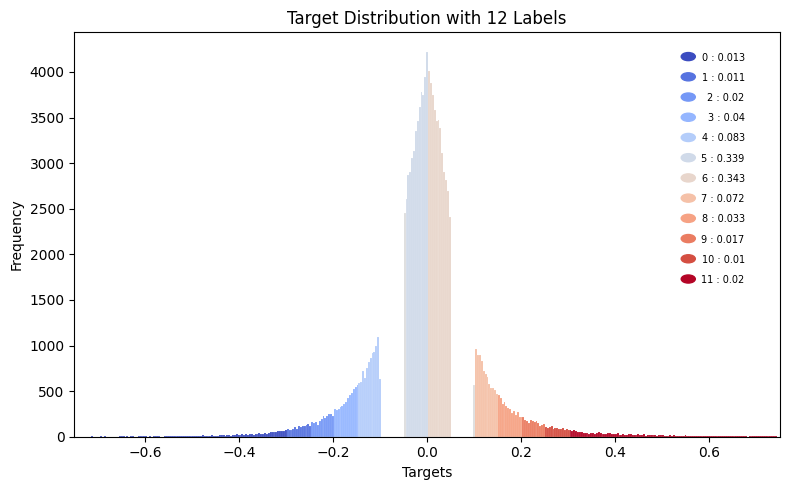

In [29]:
# For cross entropy with 12 labels, every 5%
label = 0
labels = torch.zeros_like(targets).long()
edges = [0.1,0.15,0.2,0.25,0.3]
label += 1
edges = [-n for n in edges[::-1]]
for low,high in zip(edges[:-1],edges[1:]):
  labels[(targets < high)&(targets>=low)] = label
  label+=1
labels[(targets >= -0.05)&(targets<=0)] = label
labels[(targets <= 0.05)&(targets>0)] = label+1
label+=2
edges = [0.1,0.15,0.2,0.25,0.3]
for low,high in zip(edges[:-1],edges[1:]):
  labels[(targets < high)&(targets>=low)] = label
  label+=1

labels[targets >= 0.3] = label
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [1/(value / np.sum(list(label_count.values()))) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

Counter({5: 41562, 4: 41047, 3: 10089, 6: 8787, 2: 4867, 7: 3971, 9: 3633, 0: 2842, 1: 2373, 8: 2044})
0 : 0.023 | 1 : 0.02 | 2 : 0.04 | 3 : 0.083 | 4 : 0.339 | 5 : 0.343 | 6 : 0.072 | 7 : 0.033 | 8 : 0.017 | 9 : 0.03
[42.651, 51.081, 24.905, 12.015, 2.953, 2.916, 13.795, 30.525, 59.303, 33.365]


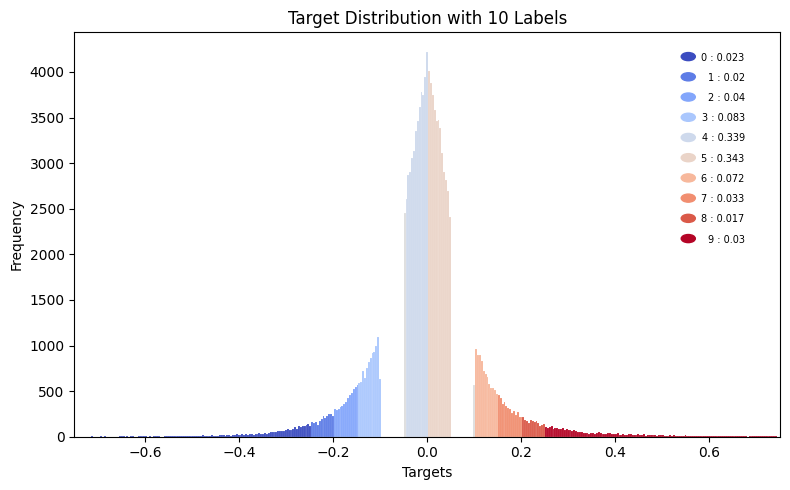

In [30]:
# For cross entropy with 10 labels, every 5%
label = 0
labels = torch.zeros_like(targets).long()
edges = [0.1,0.15,0.2,0.25]
label += 1
edges = [-n for n in edges[::-1]]
for low,high in zip(edges[:-1],edges[1:]):
  labels[(targets < high)&(targets>=low)] = label
  label+=1
labels[(targets >= -0.05)&(targets<=0)] = label
labels[(targets <= 0.05)&(targets>0)] = label+1
label+=2
edges = [0.1,0.15,0.2,0.25]
for low,high in zip(edges[:-1],edges[1:]):
  labels[(targets < high)&(targets>=low)] = label
  label+=1

labels[targets >= 0.25] = label
label_count = Counter(labels.tolist())
print(label_count)
print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
class_weights = [round(1/(value / np.sum(list(label_count.values()))),3) for key, value in sorted(label_count.items())]
print(class_weights)
generateLabelHistogram(label_count,targets)

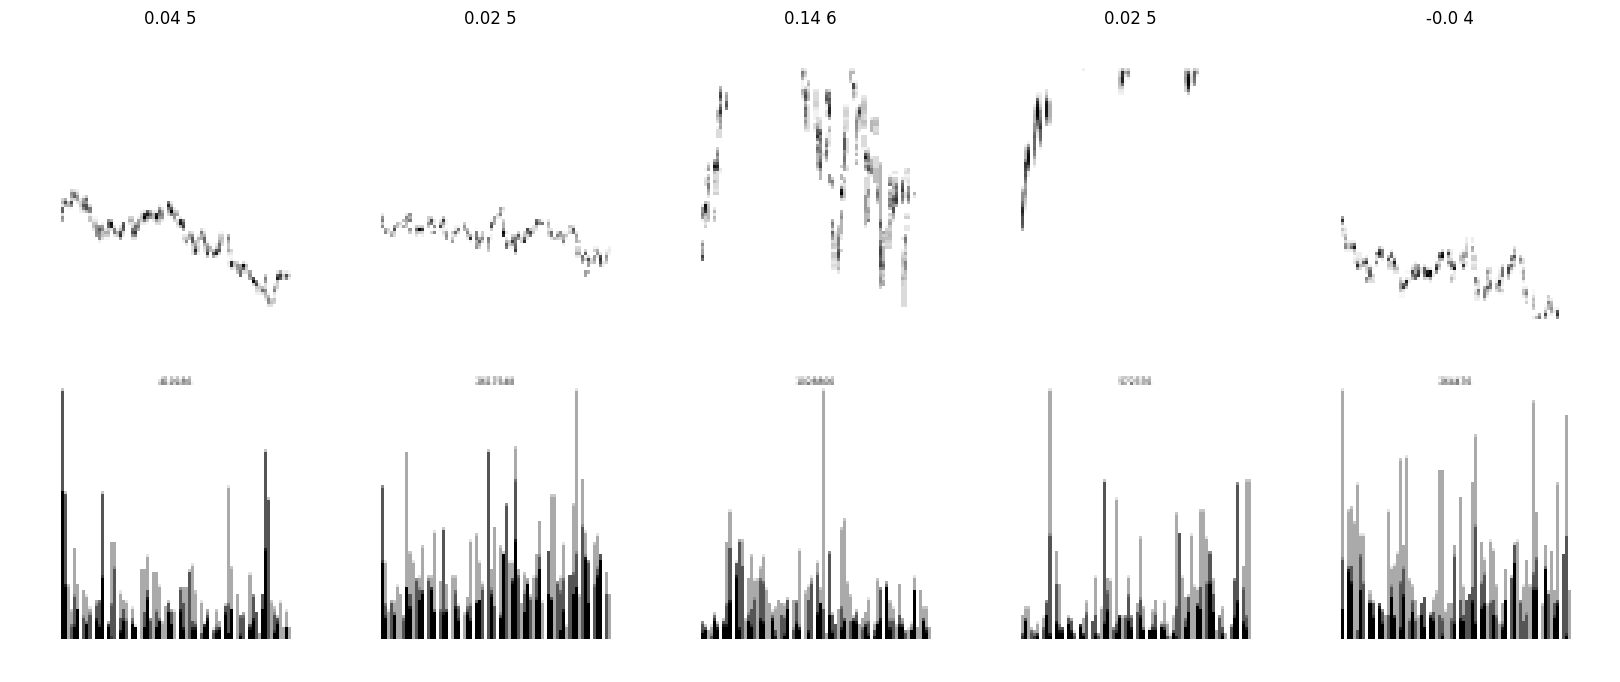

In [ ]:
# visualize some images
fig,axs = plt.subplots(2,5,figsize=(5*320/100,2*320/100),dpi=100)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(images.shape[0])

  # visualize
  axs[0,i].imshow(images[n,0,:,:],cmap='gray', aspect='auto')
  axs[1,i].imshow(images[n,1,:,:],cmap='gray', aspect='auto')
  axs[0,i].set_title(f'{round(targets[n].item(),2)} {labels[n].item()}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [ ]:
# split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.125, stratify=labels)
images = []
dev_data,test_data, dev_labels,test_labels = train_test_split(test_data, test_labels, test_size=.5, stratify=test_labels)

# PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
dev_data = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])



In [ ]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

In [ ]:
images=[]

In [ ]:
def createMSENet(printtoggle=False):

    class stockCNN(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            self.print = printtoggle

            # Convolutional layers
            self.conv1 = nn.Conv2d(2, 16, 4, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 64, 4, padding=1)
            self.bnorm2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
            self.bnorm3 = nn.BatchNorm2d(256)

            # Linear layers
            self.fc1 = nn.Linear(36864, 256)
            self.fc2 = nn.Linear(256, 64)
            self.fc3 = nn.Linear(64, 1)

        def forward(self, x):
            if self.print: print(f'Input: {list(x.shape)}')

            # First block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Third block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Reshape for linear layer
            x = x.view(x.size(0), -1)

            # Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.25, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.25, training=self.training)
            x = torch.tanh(self.fc3(x))

            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    # Create the model instance
    net = stockCNN(printtoggle)

    # Loss function
    lossfun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.0001)

    return net, lossfun, optimizer

In [ ]:
# test the model with one batch
MSEnet,lossfun,optimizer = createMSENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = MSEnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

# imgSize = images.shape[2]
# summary(MSEnet,(1,imgSize,imgSize))

In [ ]:
def trainMSEModel():
    # Number of epochs


    # Create a new model
    MSEnet, lossfun, optimizer = createMSENet(False)

    # Send the model to the GPU
    MSEnet.to(device)

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = []
    devLoss = torch.zeros(numepochs)

    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        MSEnet.train()
        batchLoss = []

        for X, y in train_loader:
            # Push data to GPU (convert to half here)
            X = X.to(device).half()
            y = y.to(device).half()

            # Check for NaN in inputs
            if torch.isnan(X).any() or torch.isnan(y).any():
                print("Warning: Found NaN values in input data.")
                continue  # Skip this batch if NaNs are found

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = MSEnet(X)
                loss = lossfun(yHat, y)

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # After scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(MSEnet.parameters(), max_norm=1.0)

            # Check gradients before unscale
            for param in MSEnet.parameters():
                if param.grad is not None and (torch.isinf(param.grad).any() or torch.isnan(param.grad).any()):
                    print("Warning: Found inf/nan gradients before optimizer step.")
                    continue  # Skip the optimizer step if gradients are invalid

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())

        # Store training loss
        trainLoss += batchLoss

        # Test performance
        MSEnet.eval()
        X, y = next(iter(dev_loader))  # Extract X, y from test dataloader

        # Push data to GPU
        X = X.to(device).half()
        y = y.to(device).half()

        with torch.no_grad(), autocast():
            yHat = MSEnet(X)
            loss = lossfun(yHat, y)

        # Extract the loss for this test epoch
        devLoss[epochi] = loss.item()

    # Return losses and trained model
    return trainLoss, devLoss, MSEnet,lossfun


In [ ]:
def trainCEModel(numepochs):
    print(f'{len(class_weights)} labels')
    # Create a new model
    CEnet, lossfun, optimizer = createCENet(False)

    # Send the model to the GPU (do not convert to half)
    CEnet.to(device)
    # Do NOT use CEnet.half()

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    devErr = torch.zeros(numepochs)
    batchLoss = []
    batchErr = []

    # Variable to store the best (lowest) validation accuracy and corresponding epoch
    best_dev_err = float('inf')
    best_epoch = -1

    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        CEnet.train()

        for X, y in train_loader:

            # Push data to GPU (do not convert to half)
            X = X.to(device)
            y = y.to(device).long()  # CrossEntropyLoss requires Long targets

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = CEnet(X)
                loss = lossfun(yHat, y)

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(CEnet.parameters(), max_norm=1.0)

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())
            batchErr.append(100*torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())

        # Store training loss and error
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = np.mean(batchErr)

        # Validation performance
        CEnet.eval()
        X, y = next(iter(dev_loader))

        # Push data to GPU
        X = X.to(device)
        y = y.to(device).long()

        with torch.no_grad(), autocast():
            yHat = CEnet(X)
            loss = lossfun(yHat, y)

        # Store validation loss and error
        devLoss[epochi] = loss.item()
        devErr[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()

        # Check if the current validation error is the lowest
        if devErr[epochi] < best_dev_err:
            best_dev_err = devErr[epochi]
            best_epoch = epochi
            # Save the model's state dict at the best epoch
            torch.save(CEnet.state_dict(), savePath+f'CE_[::2]_10labels_lowest_devError.pt')
            print(f'Saving model at epoch {epochi + 1} with lowest dev error: {best_dev_err:.2f}%')

    # Return losses and trained model
    return trainLoss, devLoss, trainErr, devErr, CEnet, lossfun, batchLoss, batchErr

In [ ]:
# create a class for the model
def createCENet(printtoggle=False):

  class stocknet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # Convolutional layers
      self.conv1 = nn.Conv2d(2, 16, 4, padding=1)
      self.bnorm1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 64, 4, padding=1)
      self.bnorm2 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)

      # Linear layers
      self.fc1 = nn.Linear(36864, 256)
      self.fc2 = nn.Linear(256, 64)
      self.fc3 = nn.Linear(64, len(class_weights))

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      # x = F.dropout(x,p=.1,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stocknet(printtoggle)

  # loss function

  lossfun = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.half).to(device) )
  # lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.001)

  return net,lossfun,optimizer

In [ ]:

def validate_data(loader):
    for X, y in loader:
        if torch.isnan(X).any() or torch.isnan(y).any():
            print("Warning: NaN detected in training data.")
            return False
    return True

# Call this function before training
if not validate_data(train_loader):
    print("Training data contains NaNs.")

In [ ]:
validate_data(test_loader)

True

In [ ]:
trainLoss,devLoss,MSEnet,lossfun = trainMSEModel()

NameError: name 'function2trainMSEModel' is not defined

In [ ]:
numepochs = 10
trainLoss,devLoss,trainErr,devErr,CEnet,CElossfun,batchLoss,batchErr = trainCEModel(numepochs)

10 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 57.10%
Epoch 2/10
Saving model at epoch 2 with lowest dev error: 47.57%
Epoch 3/10
Saving model at epoch 3 with lowest dev error: 41.57%
Epoch 4/10
Saving model at epoch 4 with lowest dev error: 41.33%
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10


In [ ]:
torch.save(CEnet.state_dict(), savePath+'CEnet_10epochs_10labels_midAndExtremes_every2ndImg_pool3_asHalf_08102024_.pth')

In [ ]:
X,y = next(iter(test_loader))
X = X.to(device).half() # push data to GPU
y = y.to(device).long() # push data to GPU
with torch.no_grad(), autocast():
    yHat = CEnet(X)
    test_loss = CElossfun(yHat, y)
testErr = 100*torch.mean((torch.argmax(yHat.cpu(),axis=1) != y.cpu()).float()).item()
print(f'Test Error : {testErr:.2f}%')


fig,ax = plt.subplots(1,2,figsize=(16,5))
xaxispoints = np.linspace(0,len(batchLoss),numepochs)
ax[0].plot(xaxispoints,trainLoss,'s-',label='Train')
ax[0].plot(xaxispoints,devLoss,'o-',label='Dev')
ax[0].plot(batchLoss,'s',label='Batch',markersize=1,alpha=0.1)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CE)')
ax[0].set_title(f'{len(class_weights)} label loss')
ax[0].legend()


ax[1].plot(xaxispoints,trainErr,'s-',label='Train')
ax[1].plot(xaxispoints,devErr,'o-',label='Dev')
ax[1].plot(batchErr,'s',label='Batch',markersize=1,alpha=0.1)
ax[1].plot(len(batchLoss),testErr,'*',label='Test',markersize=15, color='r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model dev error rate: {devErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# compute the confusion matrix without normalization
C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))

# Normalize per prediction (by columns)
column_sums = C.sum(axis=0)  # Get the sum for each column
C_normalized = C / column_sums[np.newaxis, :]  # Divide each element by its column sum

# visualize it
fig = plt.figure(figsize=(7,7))
plt.imshow(C_normalized, cmap='cividis', vmax=.7)

# make the plot look nicer
plt.xticks(range(len(class_weights)))
plt.yticks(range(len(class_weights)))
plt.title('TEST Confusion Matrix (Normalized by Prediction)')
plt.xlabel('Predicted Number')
plt.ylabel('True Number')
plt.colorbar()

C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))
# Add the values inside the squares
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        plt.text(j, i, f'{int(C[i, j])}', ha='center', va='center', color='red')

plt.show()


In [ ]:
X,y = next(iter(dev_loader))
X = X.to(device).half() # push data to GPU
y = y.to(device).long() # push data to GPU
with torch.no_grad(), autocast():
    yHat = CEnet(X)
devErr = 100*torch.mean((torch.argmax(yHat.cpu(),axis=1) != y.cpu()).float()).item()
print(f'Dev Error : {devErr:.2f}%')

# compute the confusion matrix without normalization
C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))

# Normalize per prediction (by columns)
column_sums = C.sum(axis=0)  # Get the sum for each column
C_normalized = C / column_sums[np.newaxis, :]  # Divide each element by its column sum

# visualize it
fig = plt.figure(figsize=(7,7))
plt.imshow(C_normalized, cmap='cividis', vmax=.7)

# make the plot look nicer
plt.xticks(range(len(class_weights)))
plt.yticks(range(len(class_weights)))
plt.title('DEV Confusion Matrix (Normalized by Prediction)')
plt.xlabel('Predicted Number')
plt.ylabel('True Number')
plt.colorbar()

C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))
# Add the values inside the squares
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        plt.text(j, i, f'{int(C[i, j])}', ha='center', va='center', color='red')

plt.show()

In [ ]:
# visualize some images
fig,axs = plt.subplots(2,7,figsize=(7*320/100,2*320/100),dpi=75)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(X.cpu().shape[0])

  # visualize
  axs[0,i].imshow(torch.squeeze( X.cpu()[n,0,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[1,i].imshow(torch.squeeze( X.cpu()[n,1,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[0,i].set_title(f't={round(y.cpu()[n].item(),2)} p={round(yHat.cpu()[n].item(),2)}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [ ]:
X,y = next(iter(test_loader))
X = X.to(device).half() # push data to GPU
y = y.to(device).half() # push data to GPU
with torch.no_grad(), autocast():
    yHat = MSEnet(X)
    test_loss = lossfun(yHat, y)
# yHat = MSEnet(X)
# test_loss = round(F.mse_loss(yHat,y),4)
# print(f'Test Loss : {test_loss:.4f}')
numepochs =5
plt.plot(trainLoss,'s',label='Train',markersize=1)
plt.plot(np.linspace(0,len(trainLoss),numepochs),devLoss,'o-',label='Validation')
plt.plot(np.linspace(0,len(trainLoss),numepochs)[-1],test_loss.cpu(),'r*',label='Test')
# plt.ylim((0,1))
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
# plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

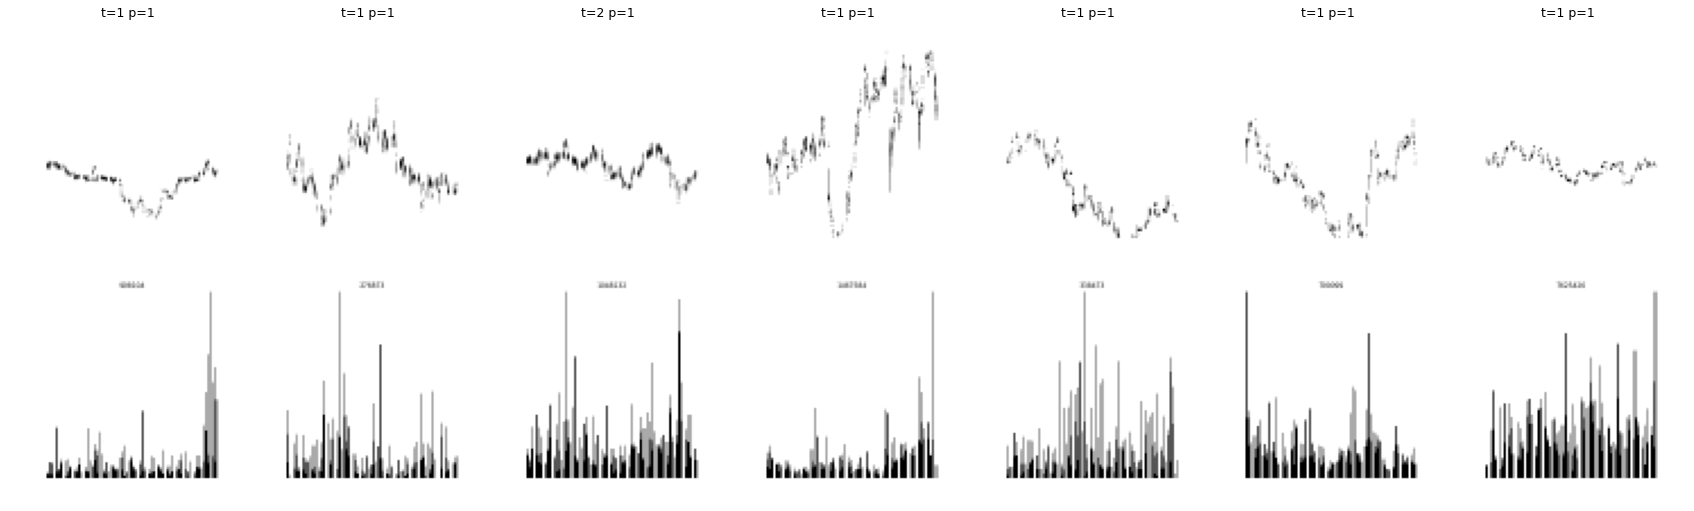

In [ ]:
# visualize some images
fig,axs = plt.subplots(2,7,figsize=(7*320/100,2*320/100),dpi=75)
i=0
while i != 7:
  #  i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(X.cpu().shape[0])
  if y.cpu()[n] !=0:
    # visualize
    axs[0,i].imshow(torch.squeeze( X.cpu()[n,0,:,:] ).detach(),cmap='gray', aspect='auto')
    axs[1,i].imshow(torch.squeeze( X.cpu()[n,1,:,:] ).detach(),cmap='gray', aspect='auto')
    axs[0,i].set_title(f't={round(y.cpu()[n].item(),2)} p={torch.argmax(yHat.cpu()[n])}')
    axs[0,i].axis('off')
    axs[1,i].axis('off')
    i+=1
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [ ]:
sum(y==1)

tensor(0, device='cuda:0')

In [ ]:
# how much does it add in volume and time to increase img size?
# add noise?

In [ ]:
'''

def trainCEModelCPU(numepochs):


  # create a new model
  net,lossfun,optimizer = createCENetCPU()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    print(f'Epoch {epochi + 1}/{numepochs}')

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:
      print(f'X shape: {X.shape}, y shape: {y.shape}')
      # push data to GPU
      X = X.to(device)
      y = y.to(device)
      print(f'Unique values in y: {y.unique()}')
      # forward pass and loss
      yHat = net(X)
      print(f'yHat shape: {yHat.shape}, y shape: {y.shape}')
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainErr,devErr,net
  '''

In [ ]:
'''
# create a class for the model
def makeBCENet(printtoggle=False):

  class stockCNN(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      self.conv1  = nn.Conv2d(2,16,4,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (106+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      self.conv2  = nn.Conv2d(16,64,4,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

      self.conv3  = nn.Conv2d(64,256,4,padding=1)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (8+2*1-3)/1 + 1 = 14/2 = 4 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(36864,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,1)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stockCNN(printtoggle)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.0001)

  return net,lossfun,optimizer

# test the model with one batch
net,lossfun,optimizer = makeBCENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

imgSize = images.shape[2]
#summary(net,(1,imgSize,imgSize))

def function2trainBCEModel():

  # number of epochs
  numepochs = 3

  # create a new model
  net,lossfun,optimizer = makeBCENet(False)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)
  # trainErr  = torch.zeros(numepochs)
  # devErr   = torch.zeros(numepochs)
  batchLoss = []
  batchAcc  = []

  # loop over epochs
  for epochi in range(numepochs):
    print(epochi)
    # loop over training data batches
    net.train()

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net,batchLoss,batchAcc
  '''